# **VAE From Scratch**
In this notebook you will implement VAE from scratch and train it using the MNIST dataset.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [14]:
BATCH_SIZE = 128
LATENT_DIM = 10
LR = 1e-3
EPOCHS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Preparing the dataset

In [15]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Encoder Module

In [16]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        # TODO:
        # 1. Flatten input images into vectors
        # 2. Pass through fc1 and apply ReLU
        # 3. Compute mean vector mu using fc_mu
        # 4. Compute log-variance vector logvar using fc_logvar
        # 5. Return mu, logvar

        input = x.view(-1, 784)
        # input = torch.flatten(x)
        out = self.fc1(input)
        out = F.relu(out)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar

# Reparameterization Module

In [17]:
def reparameterize(mu, logvar):
    # TODO:
    # 1. Compute standard deviation from log-variance
    # 2. Sample epsilon from N(0, I) with same shape
    # 3. Generate latent vector using reparameterization trick
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + std * eps
    return z

# Decoder Module

In [18]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 784)

    def forward(self, z):
        # TODO:
        # 1. Pass latent vector through fc1 + ReLU
        # 2. Pass through fc2 + Sigmoid
        # 3. Reshape output to image format (B,1,28,28)
        out = self.fc1(z)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        out = out.view(-1, 1, 28, 28)
        return out

# VAE Wrapper

In [19]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        # TODO:
        # 1. Encode input to get mu and logvar
        # 2. Sample latent vector using reparameterize
        # 3. Decode z to reconstructed image
        # 4. Return x_hat, mu, logvar
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


# VAE Loss

In [20]:
def vae_loss(x, x_hat, mu, logvar):
    # TODO:
    # 1. Compute binary cross-entropy reconstruction loss (sum)
    # 2. Compute KL divergence term
    # 3. Return total loss, recon loss, KL loss
    recon = F.binary_cross_entropy(x_hat, x, reduction='sum')
    # kl = -0.5 * torch.mean(1 + logvar - mu**2 - logvar.exp())
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl

# Train

In [21]:
model = VAE(LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model.train()
for epoch in range(1, EPOCHS + 1):
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for x, _ in train_loader:
        x = x.to(DEVICE)

        x_hat, mu, logvar = model(x)
        loss, recon, kl = vae_loss(x, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

    print(
        f"Epoch {epoch:02d} | "
        f"Loss: {total_loss / len(train_dataset):.2f} | "
        f"Recon: {total_recon / len(train_dataset):.2f} | "
        f"KL: {total_kl / len(train_dataset):.2f}"
    )


Epoch 01 | Loss: 163.85 | Recon: 150.28 | KL: 13.57
Epoch 02 | Loss: 125.65 | Recon: 109.06 | KL: 16.59
Epoch 03 | Loss: 120.55 | Recon: 103.50 | KL: 17.05
Epoch 04 | Loss: 117.77 | Recon: 100.40 | KL: 17.37
Epoch 05 | Loss: 115.98 | Recon: 98.36 | KL: 17.62
Epoch 06 | Loss: 114.72 | Recon: 96.89 | KL: 17.83
Epoch 07 | Loss: 113.71 | Recon: 95.71 | KL: 18.00
Epoch 08 | Loss: 112.83 | Recon: 94.73 | KL: 18.10
Epoch 09 | Loss: 112.13 | Recon: 93.91 | KL: 18.22
Epoch 10 | Loss: 111.50 | Recon: 93.19 | KL: 18.31
Epoch 11 | Loss: 111.00 | Recon: 92.62 | KL: 18.38
Epoch 12 | Loss: 110.47 | Recon: 92.04 | KL: 18.43
Epoch 13 | Loss: 110.12 | Recon: 91.62 | KL: 18.50
Epoch 14 | Loss: 109.72 | Recon: 91.16 | KL: 18.56
Epoch 15 | Loss: 109.36 | Recon: 90.78 | KL: 18.58
Epoch 16 | Loss: 109.06 | Recon: 90.42 | KL: 18.64
Epoch 17 | Loss: 108.80 | Recon: 90.12 | KL: 18.68
Epoch 18 | Loss: 108.52 | Recon: 89.81 | KL: 18.71
Epoch 19 | Loss: 108.26 | Recon: 89.52 | KL: 18.74
Epoch 20 | Loss: 108.01 | R

# Visualization

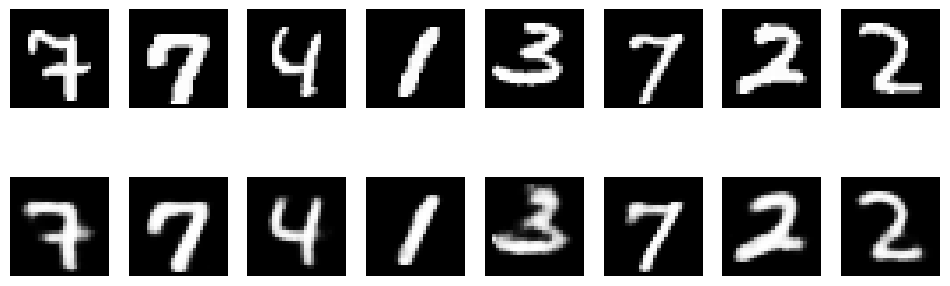

In [22]:
model.eval()
x, _ = next(iter(train_loader))
x = x.to(DEVICE)

with torch.no_grad():
    x_hat, _, _ = model(x)

n = 8
plt.figure(figsize=(12, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_hat[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.show()

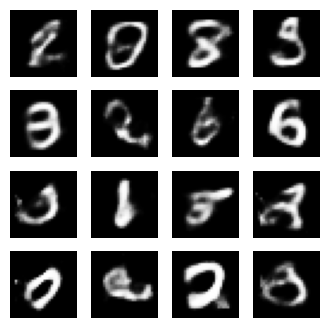

In [23]:
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(DEVICE)
    samples = model.decoder(z)

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.show()


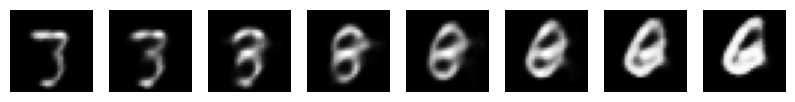

In [24]:
model.eval()
z = torch.zeros(1, LATENT_DIM).to(DEVICE)

plt.figure(figsize=(10, 4))
for i, val in enumerate(torch.linspace(-3, 3, 8)):
    z[0, 5] = val
    with torch.no_grad():
        img = model.decoder(z)
    plt.subplot(1, 8, i + 1)
    plt.imshow(img.cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.show()